![header](../header.png)

# Guia de Processamento Digital de Imagens em linguagem de programação Python

## Estudo de caso em Reconhecimento Automático de Placas Veiculares

### Descrição

Esse guia é composto de diversos notebooks que têm por principal objetivo apresentar o desenvolvimento de algoritmos em linguagem python com uso da biblioteca de visão computacional OpenCV. Para isso, toma como exemplo um estudo de caso em reconhecimento automático de placas veiculares. As imagens utilizadas são do [SSIG-ALPR Database](http://www.smartsenselab.dcc.ufmg.br/ssig-alpr-database).

### Notebook número 8

Esse notebook tem por objetivo exemplificar a **segmentação baseada em regiões** por meio do uso da **Técnica de divisores de água** ou **Watershed**. 

Nesse caso, o primeiro passo a ser dado é a importação das bibliotecas, a definição das funções úteis e a leitura das imagens.

In [1]:
import numpy as np
import cv2
from os import listdir, path
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
# Funcoes uteis 

# Funcao de leitura de imagens
def pdiguide_imgRead(path,convert=True,show=False):
    # Essa funcao cria uma lista de imagens dado o caminho (path) de um diretório.
    # Se "convert" é Verdadeiro, a função irá realizar a conversão das imagens de RGB para Grayscale
    # Se "show" é Verdadeiro, a função irá exibir as imagens carregadas
    
    img = [] # lista de imagens em tons de cinza

    number_of_files = len(listdir(path))#a função listdir forma uma lista com todos os arquivos

    if(show):
        plt.figure(figsize=[15,10]) #define a existencia de uma figura e define o seu tamanho

    #A cada iteração uma imagem é carregada e convertida para tons de cinza, 
    #ao passo que é armazenada nos vetores acima
    for i in range(0,number_of_files): 
        img.append(cv2.imread(path + str(i+1) + '.png'))
        if(convert):
            img[i]=(cv2.cvtColor(img[i],cv2.COLOR_RGB2GRAY))

        #Exibe as imagens
        if(show):
            plt.subplot(1+number_of_files/5,5,i+1)
            plt.imshow(img[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
            #xticks e yticks controlam as escalas exibidas, nesse caso, serão nulas.
            
    print("Leitura finalizada, total de imagens lidas = ",len(img))
    return img #retorna a lista de imagens
    
# Funcao apenas para exibicao da lista de imagens
def pdiguide_show(list_of_imgs, columns, titles=None):
    # Essa funcao exibe as imagens dado uma lista de imagens.
    number_of_files = len(list_of_imgs)
    for i in range(0,number_of_files): 
        plt.subplot(1+number_of_files/columns,columns,i+1) 
        plt.imshow(list_of_imgs[i],cmap='gray'),plt.xticks([]),plt.yticks([]) 
        if titles != None: plt.title(titles[i])
            
# Funcao para calcular e exibir o histograma de uma imagem 
def pdiguide_histogram(img,nbins,show=False):
    # Essa funcao calcula o histograma de um vetor 2D (imagem grayscale)
    # com valores inteiros entre 0-255.
    # Essa imagem retorna um vetor 1D com o histograma e os pontos 
    # que representam o bin_edges para plotagem do histograma.
    # Caso show seja verdadeiro ela mesmo irá plotar o histograma
    h, bin_edges = np.histogram(img.ravel(), nbins,(0,255))
    if show:
        w=256./nbins
        bin_centers = bin_edges[1:]-(w/2)
        plt.bar(bin_centers, h, width=w)
    
    return h, bin_edges

In [52]:
# Leitura das imagens
path = '../Data/'
img = pdiguide_imgRead(path)

Leitura finalizada, total de imagens lidas =  20


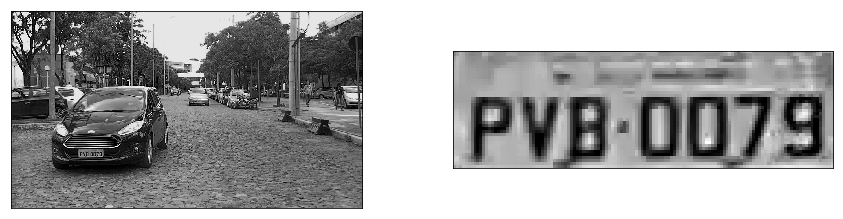

In [115]:
# Utilizando somente a imagem 0 
im_car = img[0]
im_plate = im_car[760:800,370:500] #Recorte da placa para a imagem 8

plt.figure(figsize=[15,8]) 
pdiguide_show([im_car,im_plate],2)

### Segmentação de Imagens por Regiões - Watershed

A segmentação por regiões pode ser divida em duas abordagens: segmentação por
crescimento de região e a segmentação por difusão e fusão de regiões. A primeira agrupa
os pixels ou sub-regiões em regiões maiores com base em critérios pré-definidos. O processo se inicia a partir de um conjunto de pontos "sementes" de onde a região começa a crescer
anexando pixels vizinhos com propriedades predefinidas semelhantes. A seleção do critério de similaridade é variada e depende do problema
em questão e do tipo de dados da imagem. A segunda abordagem busca em um primeiro
momento subdividir a imagem em um conjunto de regiões distintas e arbitrárias, em
seguida, fundir e/ou dividir as regiões de modo a satisfazer os critérios de segmentação (GONZALEZ; WOODS, 2006).

#### Watershed 

Conforme o autor supracitado, a técnica de Watershed (bacias hidrográficas)
se aproveita de conceitos de todas as técnicas apresentadas. O seu conceito envolve a
visualização da imagem em três dimensões, as coordenadas espaciais (x,y) e um terceiro eixo
que representa a intensidade dos pixels. Nesse tipo de representação topográfica existem
três tipos de pontos: 

- os pontos de mínimo local 
- os pontos intermediários, nos quais se uma gota de água caísse sobre eles, ela iria deslizar e cair em um ponto de mínima
- os pontos de máximo local ou picos, onde se uma gota caísse sobre ele, ela teria igual probabilidade de escorregar para dois pontos mínima. 

Os dois primeiros pontos simbolizam bacias hidrográficas e serão
considerados regiões de semelhança e o terceiro ponto formam as linhas de divisão ou
linhas de watershed. O objetivo do algoritmo de Watershed é encontrar as linhas de divisão. 

Para
compreensão desse algoritmo normalmente se faz uma analogia em relação a imersão da
topologia da imagem em um líquido. Considera-se que os pontos de mínimo são furos na
topologia. Ao mergulhar a topologia, o líquido entra pelo furo e vai preenchendo
as bacias, no momento que a água de duas bacias estão prestes a se juntar constrói-se
uma barragem, correspondente as linhas de watershed. A inundação continua até chegar
a um ponto em que só existirá o topo das barragens, que é o resultado da segmentação
(PEDRINI; SCHWARTZ, 2008).

Uma abordagem para controlar a criação de barragens é baseada no conceito de
marcadores. Um marcador é um componente conectado que pertence a imagem. Têm-se os
marcadores internos associados aos pontos de interesse e os indicadores externos associados
ao fundo.

A seguir veremos uma implementação para Watershed. Por simplicidade, vamos começar utilizando a imagem da placa, onde os objetos que queremos segmentar são as letras.

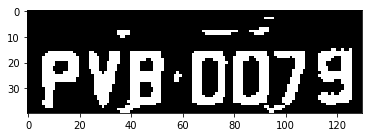

In [116]:
# Binarização da imagem (limiarização)
ret, thresh = cv2.threshold(im_plate,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh,cmap='gray')

Para redução de ruído e melhor separação da área do objeto da área de fundo, comumente usa-se como pré-processamento da técnica de Watershed operadores morfológicos. Esses operadores serão melhor abordados nos próximos notebooks.

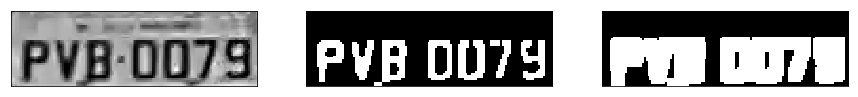

In [117]:
# Reducao de ruído com operador morfologico abertura
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

# Melhor separação entre objetos de interesse e fundo com Dilatacao
sure_bg = cv2.dilate(opening,kernel,iterations=2)

plt.figure(figsize=(15,6))
pdiguide_show([im_plate,opening,sure_bg],3)

Agora já temos o fundo (*background*) bem separado (*sure_bg*, região em preto) e precisamos ter cada objeto de interesse (*foreground*) bem isolado um do outro, tendo certeza de que o ponto demarcado corresponde a um dos objetos de interesse. Para isso, faremos uso da transformada distância. Essa transformada destaca os pixels que estão mais distantes do fundo e cria uma graduação em tons de cinza do centro do objeto (branco) ao fundo (preto). Dessa forma, após a aplicação da transformada é preciso binarizar a imagem.

*Obs: Nesse caso onde as letras não estão em contato uma com a outra, ao invés da transformada distância uma opção seria realizar um erosão.*

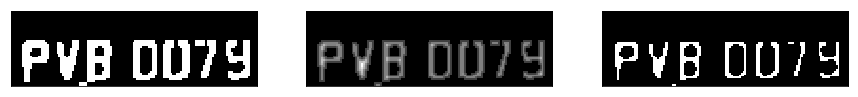

In [118]:
# Encontrando a area dos objetos de interesse
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5) # aplicacao da transformada distancia

# Binarizacao, o limiar escolhido é uma porcentagem da escala criada pela transformada distancia
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0) 

plt.figure(figsize=(15,6))
pdiguide_show([opening,dist_transform,sure_fg],3)

Agora é preciso demarcar as regiões onde a o encontro do objeto com o fundo. Nessas regiões não se pode afirmar com certeza, se os pixels pertencem ao fundo ou ao objeto. Cabe ao algoritmo de Watershed decidir. Para sinalizar as regiões desconhecidas (*unknown*) faremos a subtração entre o fundo (*background*) e os pontos de certeza de objeto (*foreground*).

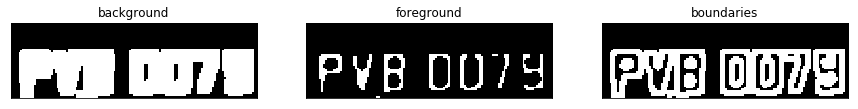

In [119]:
# Demarcando as regiões de borda
sure_fg = np.uint8(sure_fg) # uniformizando o tipo de variavel de fg
unknown = cv2.subtract(sure_bg,sure_fg) # realizando a subtração

plt.figure(figsize=(15,6))
pdiguide_show([sure_bg,sure_fg,unknown],3,['background','foreground','boundaries'])

Agora vamos criar os marcadores, para isso, basta nomear ou classificar as diferentes regiões extraídas acima com valores ou nomes diferentes. Para função de Watershed do OpenCV queremos classificar as regiões de certeza, isto é, o fundo (*background*) e os objetos (*foreground*), com valores inteiros positivos distintos e a região desconhecida (*unknown* ou *boundaries*) com zero.
 
Para isso faremos uso da função *cv2.connectedComponents()*. Essa função classidica os componentes conexos com valores positivos e define o fundo com valor zero. Um componente conexo em uma imagem binária é o conjunto de pixels de valor diferente de zero estão conectados, isto é, são vizinhos para um tipo de vizinhança fornecido. 
 
Observe que essa função não resolve totalmente nosso problema uma vez que ela define o fundo como zero. Então, precisamos modificar o valor do fundo matendo-o diferente dos demais valores e definir todos os pixels da região desconhecida como zero.

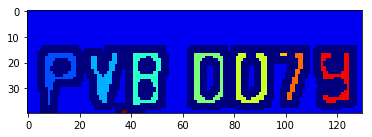

In [120]:
# Criando marcadores
ret, markers = cv2.connectedComponents(sure_fg) # observa-se que utilizou-se o foreground
# Adiciona-se 1 aos marcadores para que o background passe de 0 para 1, mas sendo diferente do foreground
markers = markers+1
# Classificando o boundaries como  zer
markers[unknown==255] = 0 # Os mesmo pontos onde unkown = 0, serão etiquetados com zero

plt.imshow(markers,cmap='jet')

Agora, vamos aplicar a função de Watersheed. Ela irá definir as bordas que separam os objetos e demarcar na matriz dos marcadores com o valor -1.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f42e4775160>,
 Text(0.5, 1.0, 'Resultado'))

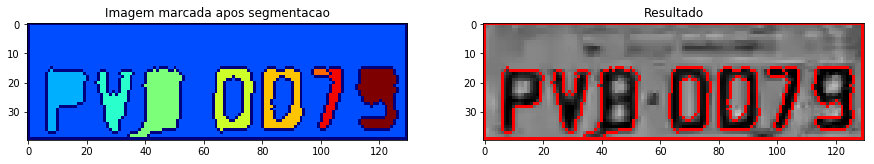

In [121]:
img_color = cv2.cvtColor(im_plate,cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(img_color,markers)
img_color[markers == -1] = [255,0,0]

plt.figure(figsize=(15,6))
plt.subplot(1,2,1), plt.imshow(markers,cmap='jet'),plt.title('Imagem marcada apos segmentacao')
plt.subplot(1,2,2), plt.imshow(img_color,cmap='jet'),plt.title('Resultado')

Nesse exemplo o Watershed ainda apresentou algumas falhas, como, para a placa do img[0], o número 7 foi entendido como duas regiões e a letra B não foi bem segmentada.

### Referências

https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html